<a href="https://colab.research.google.com/github/keithferns98/ML_Models/blob/main/Linear_reg_cross_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
housing = pd.read_csv('Housing.csv')
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
# filter only area and price
df = housing.loc[:, ['area', 'price']]
df.head()

,area,price
0,7420,13300000
1,8960,12250000
2,9960,12250000
3,7500,12215000
4,7420,11410000


In [4]:
# recaling the variables (both)
df_columns = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

# rename columns (since now its an np array)
df = pd.DataFrame(df)
df.columns = df_columns

df.head()

,area,price
0,0.396564,1.000000
1,0.502405,0.909091
2,0.571134,0.909091
3,0.402062,0.906061
4,0.396564,0.836364


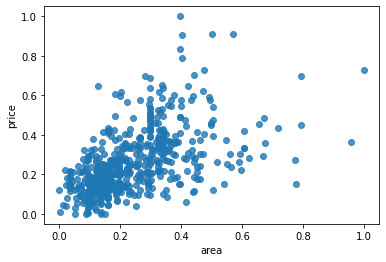

In [5]:
# visualise area-price relationship
sns.regplot(x="area", y="price", data=df, fit_reg=False)

In [6]:
# split into train and test
df_train, df_test = train_test_split(df, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 10)
print(len(df_train))
print(len(df_test))

381
164


In [7]:
# split into X and y for both train and test sets
# reshaping is required since sklearn requires the data to be in shape
# (n, 1), not as a series of shape (n, )
X_train = df_train['area']
X_train = X_train.values.reshape(-1, 1)
y_train = df_train['price']

X_test = df_test['area']
X_test = X_test.values.reshape(-1, 1)
y_test = df_test['price']

In [8]:
# fit multiple polynomial features
degrees = [1, 2, 3, 6, 10, 20]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)

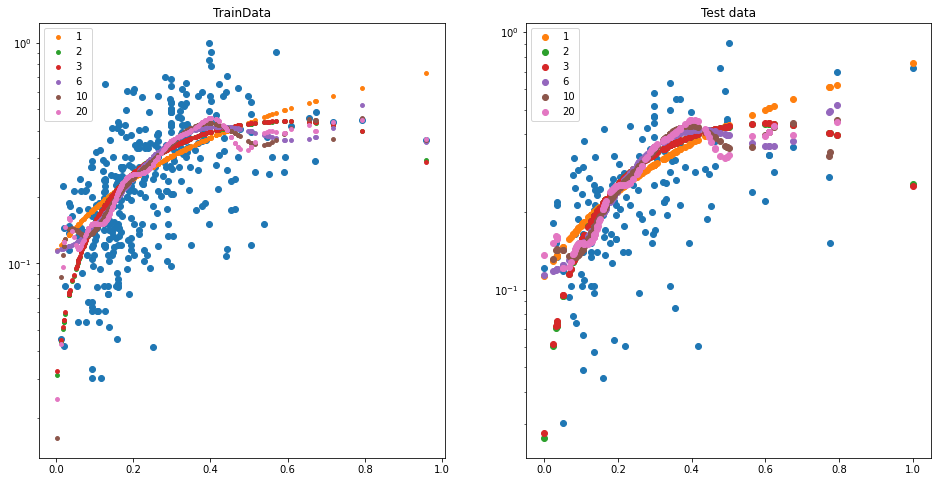

In [9]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.scatter(X_train,y_train)
plt.yscale('log')
plt.title('TrainData')
for i, degree in enumerate(degrees):    
    plt.scatter(X_train, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

In [10]:
print('r-squaredvalues \n')
for i,degree in enumerate(degrees):
    train_r2=round(sklearn.metrics.r2_score(y_train,y_train_pred[:,i]),2)
    test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

r-squaredvalues 

Polynomial degree 1: train score=0.29, test score=0.25
Polynomial degree 2: train score=0.34, test score=0.22
Polynomial degree 3: train score=0.34, test score=0.22
Polynomial degree 6: train score=0.36, test score=0.11
Polynomial degree 10: train score=0.37, test score=-108.76
Polynomial degree 20: train score=0.38, test score=-297146555779.79


1. Building a Model Without Cross-Validation
Let's now build a multiple regression model. First, let's build a vanilla MLR model without any cross-validation etc.

In [11]:
#Data Preparation

binary_vars_list=['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']

def binary_map(x):
    return x.map({'yes':1,'no':0})

housing[binary_vars_list]=housing[binary_vars_list].apply(binary_map)


In [12]:
housing

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,unfurnished
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,semi-furnished
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,unfurnished
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,furnished


In [13]:
#dummy variable
status=pd.get_dummies(housing['furnishingstatus'],drop_first=True)
status.head()

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [14]:
housing1=pd.concat([housing,status],axis=1)
housing1.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [15]:
housing1.drop(['furnishingstatus'],axis=1,inplace=True)
housing1.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


In [16]:
df_train,df_test=train_test_split(housing1,train_size=0.7,test_size=0.3,random_state=100)
scaler=MinMaxScaler()
numeric_vars=['area','bedrooms','bathrooms','stories','parking','price']
df_train[numeric_vars]=scaler.fit_transform(df_train[numeric_vars])
df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


In [17]:
df_test[numeric_vars]=scaler.fit_transform(df_test[numeric_vars])
df_test.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,0.247651,0.084536,0.333333,0.000000,0.333333,1,0,0,0,0,0.000000,1,1,0
54,0.530201,0.298969,0.333333,0.333333,0.333333,1,1,0,0,1,0.333333,0,1,0
171,0.328859,0.592371,0.333333,0.000000,0.000000,1,0,0,0,0,0.333333,1,1,0
244,0.261745,0.252234,0.333333,0.000000,0.333333,1,1,1,0,0,0.000000,1,1,0
268,0.245638,0.226804,0.666667,0.000000,0.333333,1,0,0,0,1,0.000000,0,1,0


In [18]:
y_train=df_train.pop('price')
X_train=df_train

y_test=df_test.pop('price')
X_test=df_test

In [19]:
lm=LinearRegression()
#lm.fit(X_train,y_train)

rfe=RFE(lm,10)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=10, step=1, verbose=0)

In [20]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('area', True, 1),
 ('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', True, 1),
 ('guestroom', True, 1),
 ('basement', False, 3),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('semi-furnished', False, 4),
 ('unfurnished', False, 2)]

In [21]:
y_pred=rfe.predict(X_test)

In [22]:
import sklearn

In [23]:
r2_score=sklearn.metrics.r2_score(y_test,y_pred)
r2_score

0.5812051458999574

In [24]:
# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5350445027578822


2. Problems in the Current Approach
In train-test split, we have three options:

Simply split into train and test: But that way tuning a hyperparameter makes the model 'see' the test data (i.e. knowledge of test data leaks into the model)

Split into train, validation, test sets: Then the validation data would eat into the training set

Cross-validation: Split into train and test, and train multiple models by sampling the train set. Finally, just test once on the test set.

In [25]:
#Cross_val_Score
scores=cross_val_score(lm,X_train,y_train,scoring='r2',cv=5)
scores

array([0.6829775 , 0.69324306, 0.6762109 , 0.61782891, 0.59266171])

In [26]:
#KFold CV
kfold=KFold(n_splits=5,shuffle=True,random_state=100)
scores=cross_val_score(lm,X_train,y_train,cv=kfold,scoring='r2')

In [27]:
scores

array([0.59930574, 0.71307628, 0.61325733, 0.62739077, 0.6212937 ])

In [28]:
# can tune other metrics, such as MSE
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-0.00806336, -0.00658776, -0.0064797 , -0.0070743 , -0.01523682])

In [29]:
fold=KFold(n_splits=5,shuffle=True,random_state=100)

hyper_params=[{'n_features_to_select':list(range(1,14))}]

#perform gridsearch cv

lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm) 

model_cv=GridSearchCV(rfe,
                      param_grid=hyper_params,
                      scoring='r2',
                      verbose=1,
                      return_train_score=True)
model_cv.fit(X_train,y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.6s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [30]:
model_cv.best_params_

{'n_features_to_select': 12}

In [31]:
cv_results=pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.012247,0.000526,0.001470,0.000068,1,{'n_features_to_select': 1},0.332126,0.354583,0.313473,0.208356,0.193695,0.280447,0.066303,13,0.269598,0.266078,0.274238,0.293756,0.316843,0.284103,0.018961
1,0.010843,0.000329,0.001380,0.000048,2,{'n_features_to_select': 2},0.564088,0.476047,0.535103,0.409265,0.386452,0.474191,0.068860,12,0.456277,0.478146,0.466582,0.489266,0.514996,0.481054,0.020255
2,0.011727,0.003285,0.001653,0.000691,3,{'n_features_to_select': 3},0.547223,0.589021,0.601719,0.498255,0.464872,0.540218,0.052251,9,0.542008,0.533796,0.532540,0.551370,0.575501,0.547043,0.015746
3,0.008845,0.000313,0.001509,0.000304,4,{'n_features_to_select': 4},0.581111,0.547400,0.548076,0.468244,0.461748,0.521316,0.047617,11,0.559265,0.565411,0.583286,0.563045,0.584210,0.571043,0.010561
4,0.007903,0.000135,0.001273,0.000074,5,{'n_features_to_select': 5},0.591194,0.549705,0.572553,0.493925,0.470339,0.535543,0.046154,10,0.600268,0.569250,0.596139,0.602052,0.589408,0.591424,0.011909
5,0.007520,0.000734,0.001191,0.000024,6,{'n_features_to_select': 6},0.611143,0.535911,0.566240,0.583399,0.512358,0.561810,0.034744,8,0.605035,0.592223,0.639119,0.636415,0.632917,0.621142,0.018926
6,0.006567,0.000230,0.001229,0.000106,7,{'n_features_to_select': 7},0.660339,0.531479,0.588949,0.592931,0.533003,0.581340,0.047446,7,0.637852,0.599716,0.650758,0.638769,0.658031,0.637025,0.020127
7,0.005963,0.000283,0.001165,0.000062,8,{'n_features_to_select': 8},0.665153,0.582549,0.591880,0.605447,0.568750,0.602756,0.033417,6,0.639167,0.626099,0.653133,0.658033,0.683933,0.652073,0.019457
8,0.005150,0.000125,0.001094,0.000040,9,{'n_features_to_select': 9},0.692573,0.670759,0.630966,0.620179,0.585970,0.640089,0.037693,5,0.650771,0.654203,0.663114,0.666674,0.688326,0.664618,0.013182
9,0.004444,0.000097,0.001191,0.000059,10,{'n_features_to_select': 10},0.681441,0.667416,0.648982,0.624969,0.589166,0.642395,0.032653,4,0.662694,0.665251,0.669401,0.674336,0.698179,0.673972,0.012730


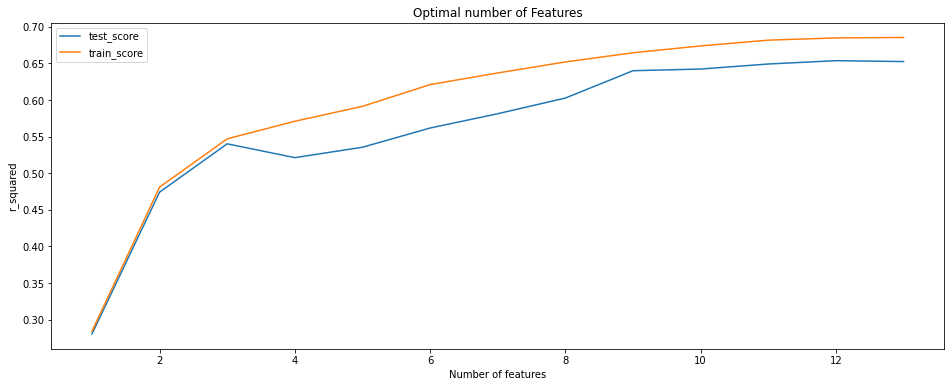

In [32]:
plt.figure(figsize=(16,6))
plt.plot(cv_results['param_n_features_to_select'],cv_results['mean_test_score'])
plt.plot(cv_results['param_n_features_to_select'],cv_results['mean_train_score'])
plt.xlabel('Number of features')
plt.ylabel('r_squared')
plt.title('Optimal number of Features')
plt.legend(['test_score','train_score'],loc='upper_left')
